# Model 1 - UDE Framework

**System:**
$$\frac{dM}{dt} = f(P) - M$$
$$\frac{dE}{dt} = M - E$$
$$\frac{dP}{dt} = E - d \cdot P$$

**Unknown:** Function $f(P)$  
**Unknown Parameter:** $d$


In [29]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
sys.path.append('..')

from ude_framework import (
    DataGenerator, 
    create_ode_system,
    create_neural_network,
    create_ude,
    UDETrainer,
    UDEEvaluator
)

%matplotlib inline
np.random.seed(42)
torch.manual_seed(42)

print("✓ UDE Framework loaded!")


✓ UDE Framework loaded!


In [30]:
# ============================================================================
# CONFIGURE EVERYTHING HERE
# ============================================================================

# ----------------------------------------------------------------------------
# 1. DATA FILES
# ----------------------------------------------------------------------------
MEASUREMENTS_FILE = 'model_1_measurements.csv'
INITIAL_CONDITIONS_FILE = 'model_1_initial_conditions.csv'

# State variable names
STATE_NAMES = ['M', 'E', 'P']

# Which states are observed in measurements
OBSERVED_STATES = ['M']  # Only M is measured
OBSERVED_INDICES = [STATE_NAMES.index(name) for name in OBSERVED_STATES]

# ----------------------------------------------------------------------------
# 2. UDE STRUCTURE (partial known + NN for unknown)
# ----------------------------------------------------------------------------
def ude_ode_equations(t, y, nn_outputs, known_params):
    """
    UDE for Model 1:
    - KNOWN: linear degradation/production terms
    - UNKNOWN: f(P) learned by NN
    - LEARNABLE PARAMETER: d (unknown degradation rate)
    
    System equations:
    dM/dt = f(P) - M
    dE/dt = M - E
    dP/dt = E - d*P
    """
    M = y[..., 0:1]
    E = y[..., 1:2]
    P = y[..., 2:3]
    
    # Get NN output for f(P) - this is the unknown function we're learning
    f_P_nn = nn_outputs['f_P_nn']
    if f_P_nn.dim() > 2:
        f_P_nn = f_P_nn.squeeze(-1)
    
    # Learnable parameter d (degradation rate - unknown parameter)
    d = known_params.get('d_learnable', torch.tensor(0.5))
    
    # System structure (known), but f(P) and d are learned
    dM_dt = f_P_nn - M
    dE_dt = M - E
    dP_dt = E - d * P
    
    return torch.cat([dM_dt, dE_dt, dP_dt], dim=-1)

# Known parameters for UDE (we'll add learnable d later)
KNOWN_PARAMS = {}

# ----------------------------------------------------------------------------
# 3. NEURAL NETWORK CONFIGURATION
# ----------------------------------------------------------------------------
NN_INPUT_DIM = 1   # f depends on P
NN_OUTPUT_DIM = 1  # outputs f(P)

def nn_input_extractor(y):
    """Extract P (third state) for f(P)"""
    return y[..., 2:3]  # Returns P

# Architecture
NN_ARCHITECTURE = 'flexible'
NN_CONFIG = {
    'hidden_dims': [64, 64, 64],
    'activation': 'tanh',
    'final_activation': 'softplus',  # f(P) should be positive
    'use_batch_norm': False,
    'dropout': 0.0
}

NN_NAME = 'f_P_nn'

# ----------------------------------------------------------------------------
# 4. TRAINING CONFIGURATION
# ----------------------------------------------------------------------------
N_EPOCHS = 1000
LEARNING_RATE = 1e-3
OPTIMIZER = 'adam'
WEIGHT_DECAY = 0.0
GRAD_CLIP = 1.0

SCHEDULER_TYPE = 'plateau'
SCHEDULER_PARAMS = {
    'factor': 0.5,
    'patience': 80,
    'min_lr': 1e-6,
    'verbose': False
}

ODE_SOLVER = 'dopri5'
ODE_RTOL = 1e-6
ODE_ATOL = 1e-8

LOSS_TYPE = 'mse'
STATE_WEIGHTS = [1.0, 0.0, 0.0]  # Only fit M (the observed state)

PRINT_EVERY = 10

# ----------------------------------------------------------------------------
# 5. VISUALIZATION OF LEARNED FUNCTION
# ----------------------------------------------------------------------------
# We'll visualize the learned f(P) function after training
FUNCTION_INPUT_RANGE = np.linspace(0, 5, 300)
FUNCTION_INPUT_NAME = 'P Concentration'
FUNCTION_OUTPUT_NAME = 'f(P) [Learned]'

print("✓ Configuration complete!")


✓ Configuration complete!


## 1. Load Data


In [31]:
# Load data from CSV files

# Load measurements
measurements_df = pd.read_csv(MEASUREMENTS_FILE)
t = measurements_df['t'].values
y_measured = measurements_df[OBSERVED_STATES].values  # Only measured states

# Load initial conditions
ic_df = pd.read_csv(INITIAL_CONDITIONS_FILE)
y0 = ic_df[STATE_NAMES].values[0]  # Get first row with all states

# Since we only observe M, we need to create full state arrays
# For training, we'll only use the observed states (via STATE_WEIGHTS)
n_points = len(t)
n_states = len(STATE_NAMES)

# Create arrays for all states (we don't have true values for E and P, only M)
y_noisy = np.zeros((n_points, n_states))
y_noisy[:, OBSERVED_INDICES] = y_measured  # Fill in measured states

# For plotting/comparison, we'll use the same for y_true (since we don't have ground truth)
y_true = y_noisy.copy()

print(f"✓ Loaded {len(t)} measurement points from t={t[0]:.2f} to {t[-1]:.2f}")
print(f"  States: {STATE_NAMES}")
print(f"  Observed states: {OBSERVED_STATES}")
print(f"  Initial conditions: {y0}")


✓ Loaded 40 measurement points from t=0.00 to 6.00
  States: ['M', 'E', 'P']
  Observed states: ['M']
  Initial conditions: [0. 0. 0.]


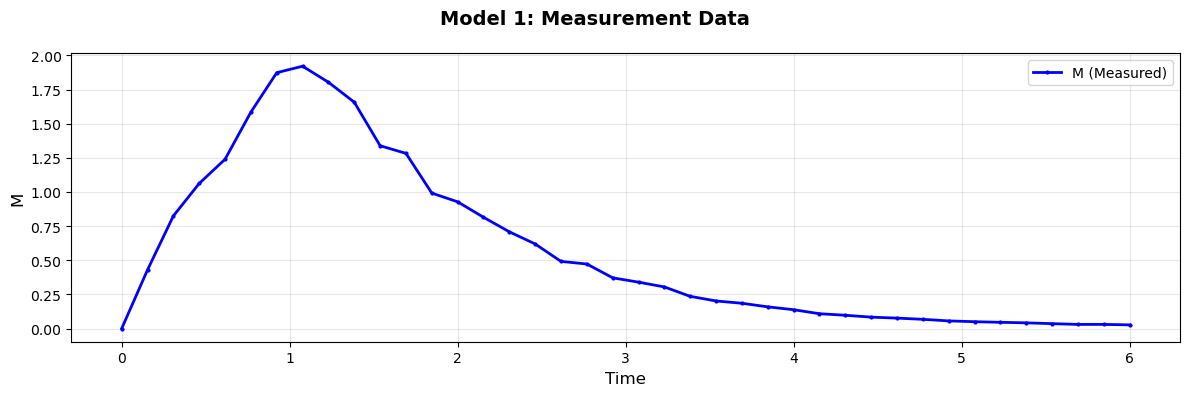

In [32]:
# Visualize data
fig, ax = plt.subplots(1, 1, figsize=(12, 4))

# Only plot M since that's what we observed
m_idx = OBSERVED_INDICES[0]
ax.plot(t, y_noisy[:, m_idx], 'b.-', label='M (Measured)', linewidth=2, markersize=4)
ax.set_ylabel('M', fontsize=12)
ax.set_xlabel('Time', fontsize=12)
ax.legend()
ax.grid(True, alpha=0.3)

plt.suptitle('Model 1: Measurement Data', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


## 2. Build UDE Model


In [33]:
# Create neural network
nn_model = create_neural_network(
    input_dim=NN_INPUT_DIM,
    output_dim=NN_OUTPUT_DIM,
    architecture=NN_ARCHITECTURE,
    **NN_CONFIG
)

print("Neural Network:")
print(nn_model)
print(f"\nParameters: {nn_model.count_parameters():,}")


Neural Network:
FlexibleNN(
  (net): Sequential(
    (0): Linear(in_features=1, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): Tanh()
    (6): Linear(in_features=64, out_features=1, bias=True)
    (7): Softplus(beta=1.0, threshold=20.0)
  )
)

Parameters: 8,513


In [34]:
# Wrap NN to extract correct input from state vector
class NNWrapper(nn.Module):
    def __init__(self, nn, input_extractor):
        super().__init__()
        self.nn = nn
        self.input_extractor = input_extractor
    
    def forward(self, t, y):
        nn_input = self.input_extractor(y)
        return self.nn(t, nn_input)

wrapped_nn = NNWrapper(nn_model, nn_input_extractor)

# Add learnable parameter d
d_learnable = nn.Parameter(torch.tensor(0.5))  # Initial guess
KNOWN_PARAMS['d_learnable'] = d_learnable

# Create UDE
ude_model = create_ude(
    n_states=len(STATE_NAMES),
    ode_func=ude_ode_equations,
    neural_networks={NN_NAME: wrapped_nn},
    known_params=KNOWN_PARAMS
)

# Register d as a parameter
ude_model.register_parameter('d_learnable', d_learnable)

print(f"\n✓ UDE Model created!")
print(f"  NN parameters: {ude_model.count_parameters()['total']}")
print(f"  Initial d: {d_learnable.item():.4f}")



✓ UDE Model created!
  NN parameters: 8513
  Initial d: 0.5000


## 3. Train UDE


In [35]:
# Convert to tensors
t_torch = torch.tensor(t, dtype=torch.float32)
y_noisy_torch = torch.tensor(y_noisy, dtype=torch.float32)
y_true_torch = torch.tensor(y_true, dtype=torch.float32)
y0_torch = torch.tensor(y0, dtype=torch.float32)

# Create trainer
trainer = UDETrainer(
    ude_model=ude_model,
    optimizer_name=OPTIMIZER,
    learning_rate=LEARNING_RATE,
    scheduler_type=SCHEDULER_TYPE,
    scheduler_params=SCHEDULER_PARAMS,
    weight_decay=WEIGHT_DECAY,
    grad_clip=GRAD_CLIP,
    ode_solver=ODE_SOLVER,
    ode_rtol=ODE_RTOL,
    ode_atol=ODE_ATOL
)

print("✓ Trainer initialized")


✓ Trainer initialized


/opt/miniconda3/envs/himanshu-quant-research/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [36]:
# Train!
print(f"\n{'='*60}")
print(f"TRAINING ({N_EPOCHS} epochs)")
print(f"{'='*60}\n")

# Convert weights to tensor if provided
weights_torch = torch.tensor(STATE_WEIGHTS, dtype=torch.float32) if STATE_WEIGHTS is not None else None

trainer.train(
    y0=y0_torch,
    t=t_torch,
    y_true=y_noisy_torch,
    n_epochs=N_EPOCHS,
    weights=weights_torch,
    loss_type=LOSS_TYPE,
    print_every=PRINT_EVERY
)

print(f"\n✓ Training complete!")
print(f"  Learned d: {ude_model.d_learnable.item():.4f}")



TRAINING (1000 epochs)

Starting training for 1000 epochs...
Optimizer: Adam
Learning rate: 0.001
ODE solver: dopri5

Epoch 1/1000 | Loss: 0.479811 | LR: 0.001000 | Grad: 0.3643
Epoch 10/1000 | Loss: 0.398338 | LR: 0.001000 | Grad: 0.2641
Epoch 20/1000 | Loss: 0.215920 | LR: 0.001000 | Grad: 0.6269
Epoch 30/1000 | Loss: 0.033586 | LR: 0.001000 | Grad: 0.2494
Epoch 40/1000 | Loss: 0.003164 | LR: 0.001000 | Grad: 0.0098
Epoch 50/1000 | Loss: 0.005406 | LR: 0.001000 | Grad: 0.0525
Epoch 60/1000 | Loss: 0.005539 | LR: 0.001000 | Grad: 0.0680
Epoch 70/1000 | Loss: 0.004024 | LR: 0.001000 | Grad: 0.0359
Epoch 80/1000 | Loss: 0.003102 | LR: 0.001000 | Grad: 0.0215
Epoch 90/1000 | Loss: 0.002941 | LR: 0.001000 | Grad: 0.0061
Epoch 100/1000 | Loss: 0.002954 | LR: 0.001000 | Grad: 0.0076
Epoch 110/1000 | Loss: 0.002924 | LR: 0.001000 | Grad: 0.0069
Epoch 120/1000 | Loss: 0.002895 | LR: 0.001000 | Grad: 0.0044
Epoch 130/1000 | Loss: 0.002879 | LR: 0.001000 | Grad: 0.0042
Epoch 140/1000 | Loss: 0

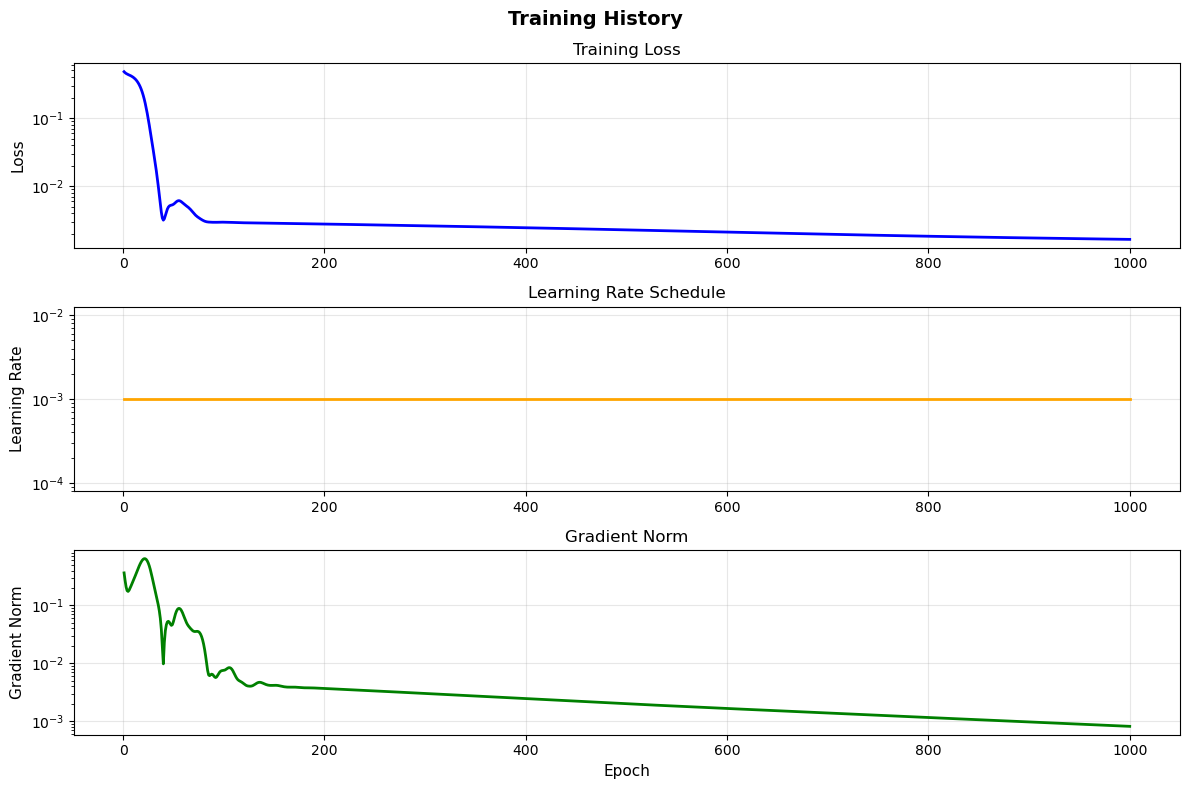

In [37]:
# Plot training history
history = trainer.get_history()
evaluator = UDEEvaluator(ude_model, STATE_NAMES)
evaluator.plot_training_history(history)


## 4. Evaluate UDE Performance


In [38]:
# Get predictions
with torch.no_grad():
    y_pred = trainer.forward_solve(y0_torch, t_torch).numpy()

# Compute metrics (only for M, the observed state)
m_idx = OBSERVED_INDICES[0]
mse = np.mean((y_pred[:, m_idx] - y_true[:, m_idx])**2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_pred[:, m_idx] - y_true[:, m_idx]))

print(f"\n{'='*60}")
print("PREDICTION METRICS (for M)")
print(f"{'='*60}")
print(f"  MSE:  {mse:.6f}")
print(f"  RMSE: {rmse:.6f}")
print(f"  MAE:  {mae:.6f}")
print(f"{'='*60}")



PREDICTION METRICS (for M)
  MSE:  0.001650
  RMSE: 0.040624
  MAE:  0.025859


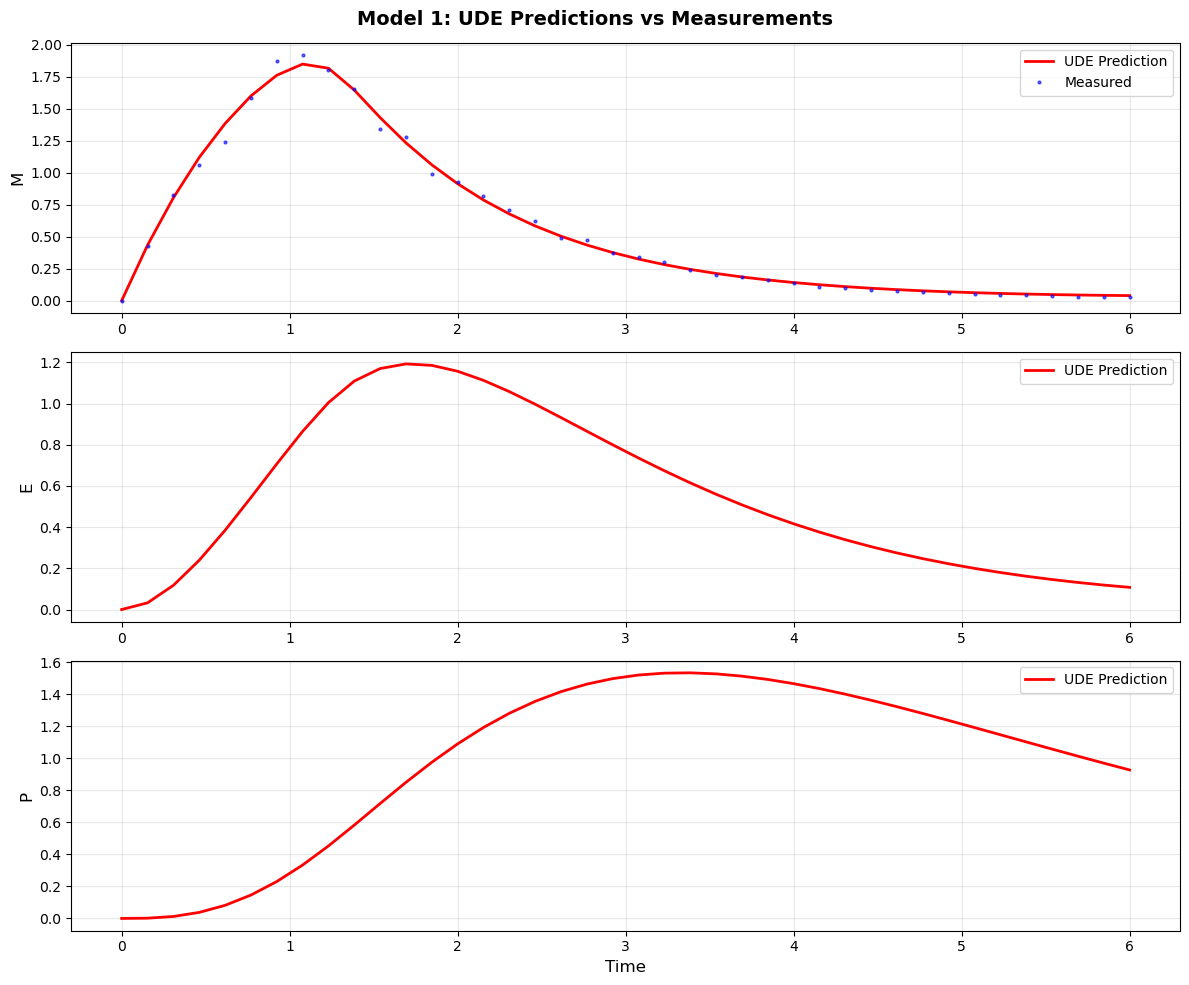

In [39]:
# Plot trajectories (all 3 states)
fig, axes = plt.subplots(3, 1, figsize=(12, 10))

for i, (ax, name) in enumerate(zip(axes, STATE_NAMES)):
    ax.plot(t, y_pred[:, i], 'r-', label='UDE Prediction', linewidth=2)
    
    # Only plot measurements for M
    if i == m_idx:
        ax.plot(t, y_true[:, i], 'b.', label='Measured', alpha=0.6, markersize=4)
    
    ax.set_ylabel(name, fontsize=12)
    ax.legend()
    ax.grid(True, alpha=0.3)

axes[-1].set_xlabel('Time', fontsize=12)
plt.suptitle('Model 1: UDE Predictions vs Measurements', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


## 5. Visualize Learned Function f(P)


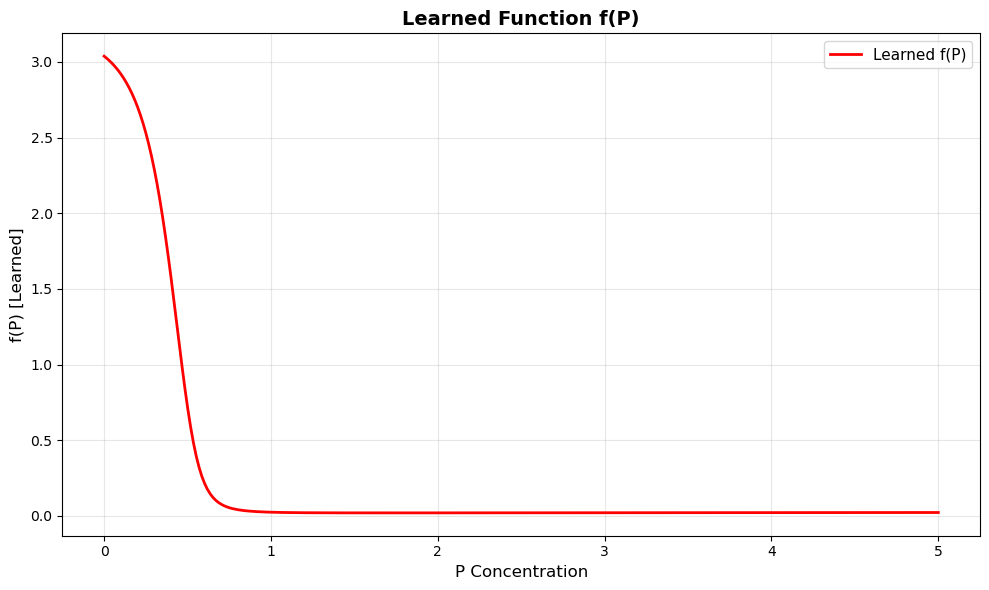

In [40]:
# Visualize the learned f(P) function
P_range = torch.tensor(FUNCTION_INPUT_RANGE.reshape(-1, 1), dtype=torch.float32)
t_dummy = torch.zeros_like(P_range[:, 0])

with torch.no_grad():
    f_P_learned = nn_model(t_dummy, P_range).numpy()

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(FUNCTION_INPUT_RANGE, f_P_learned, 'r-', linewidth=2, label='Learned f(P)')
ax.set_xlabel(FUNCTION_INPUT_NAME, fontsize=12)
ax.set_ylabel(FUNCTION_OUTPUT_NAME, fontsize=12)
ax.set_title('Learned Function f(P)', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## 6. Parameter Summary


In [41]:
# Display learned parameters
print("\n" + "="*60)
print("LEARNED PARAMETERS")
print("="*60)
print(f"\nParameter d (degradation rate):")
print(f"  Learned value: {ude_model.d_learnable.item():.4f}")
print("\nNeural Network f(P):")
print(f"  Total parameters: {nn_model.count_parameters()}")
print("  Architecture: 1 -> 64 -> 64 -> 64 -> 1")
print("  Activation: tanh + softplus (final)")
print("="*60)



LEARNED PARAMETERS

Parameter d (degradation rate):
  Learned value: 0.4111

Neural Network f(P):
  Total parameters: 8513
  Architecture: 1 -> 64 -> 64 -> 64 -> 1
  Activation: tanh + softplus (final)
